In [7]:
# DEPS

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [8]:
# DATA

# train_dat = 81 cols, 1460 rows
labelled_dat = pd.read_csv('./train.csv')
labelled_X = labelled_dat.drop(['SalePrice'], axis=1)
labelled_y = labelled_dat['SalePrice']

# test_dat = 80 cols, 1459 rows
unlabelled_X = pd.read_csv('./test.csv')

# split labelled data into a train and hold out set
X_train, X_hold_out, y_train, y_hold_out = train_test_split(labelled_X, labelled_y, test_size=0.3, random_state=24601)

# convenience for printing wide dataframes
pd.options.display.max_columns = 100

In [9]:
# EVALUATION MEASURE

def log_rmse(y, yhat):
    '''TODO: DOCSTRING'''
    diff_sq = (np.log(y) - np.log(yhat)) ** 2
    return (diff_sq.sum() / y.size) ** 0.5

In [5]:
# MODEL 1
# Predicting price as mean
    
# Holdout set
yhat = pd.Series(y_train.mean(), index=y_hold_out.index)
print('Hold out set error: {}'.format(log_rmse(y_hold_out, yhat)))

# Training set
yhat = pd.Series(labelled_y.mean(), index=labelled_y.index)
print('Training set error: {}'.format(log_rmse(labelled_y, yhat)))

# Submit the model
# unlabelled_X['SalePrice'] = pd.Series(labelled_y.mean(), index=unlabelled_X.index)
# unlabelled_X[['Id', 'SalePrice']].to_csv('model1.csv', index=False)

Hold out set error: 0.4063295915339476
Training set error: 0.40760050769850525


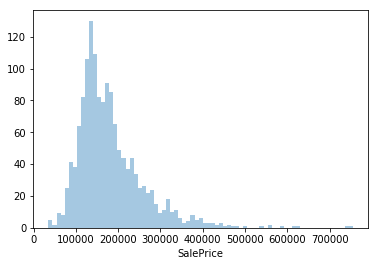

In [5]:
# EDA - what's the distribution of Sale Prices?

sns.distplot(labelled_dat['SalePrice'],bins=75, kde=False)

In [69]:
# Model 2
# Predicting price as median

# Holdout set
yhat = pd.Series(y_train.median(), index=y_hold_out.index)
print('Hold out set error: {}'.format(log_rmse(y_hold_out, yhat)))

# Training set
yhat = pd.Series(labelled_y.median(), index=labelled_y.index)
error = log_rmse(labelled_y, yhat)
print('Training set error: {}'.format(error))

# Submit the model
# unlabelled_X['SalePrice'] = pd.Series(labelled_y.median(), index=unlabelled_X.index)
# unlabelled_X[['Id', 'SalePrice']].to_csv('model2.csv', index=False)

Hold out set error: 0.39253342189309776
Training set error: 0.3999509997226266


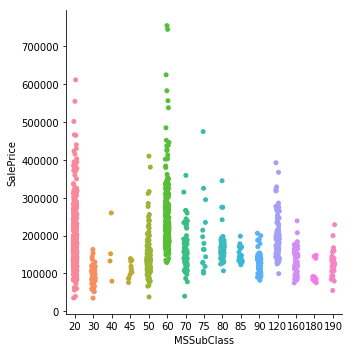

In [7]:
# EDA - Do properties of different types (MSSubClass) have different prices?

sns.catplot(x="MSSubClass", y="SalePrice", data=labelled_dat)

In [70]:
# Model 3 
# Predicting price as median of the MSSubClass

# Hold out set
train_medians = pd.concat([X_train, y_train], axis=1)[['MSSubClass', 'SalePrice']].groupby('MSSubClass').median()
yhat = X_hold_out.apply(lambda p: train_medians.loc[p.loc['MSSubClass']][0], axis=1)
print('Hold out set error: {}'.format(log_rmse(y_hold_out, yhat)))

# Training set
labelled_dat_medians = labelled_dat[['MSSubClass', 'SalePrice']].groupby('MSSubClass').median()
yhat = labelled_dat.apply(lambda p: labelled_dat_medians.loc[p.loc['MSSubClass']][0], axis=1)
print('Training set error: {}'.format(log_rmse(labelled_y, yhat)))

# Small hiccup - The MSSubClass value `150` is in the test set but not train set
# - I can see there's only one property with this value
# - I'm filling it in with the global median.
# - print(train_dat[['Id', 'MSSubClass']].groupby('MSSubClass').count())
# - print(test_dat[['Id', 'MSSubClass']].groupby('MSSubClass').count())
train_medians.loc[150] = labelled_y.median()

# Submit the model
# y_hat = unlabelled_X.apply(lambda p: train_medians.loc[p.loc['MSSubClass']][0], axis=1)
# unlabelled_X['SalePrice'] = y_hat
# unlabelled_X[['Id', 'SalePrice']].to_csv('model3.csv', index=False)

Hold out set error: 0.3223877195907782
Training set error: 0.3323846436857664


In [71]:
# Curiosity
# If you one hot encode the MSSubClass and do a linear regression (not using any other features)..
# - Q: how would you expect it to perform relative to using the median for each group (by MSSubClass)? 
# - A: almost identically.

# Training set
X = pd.get_dummies(labelled_X['MSSubClass'])
regr = linear_model.LinearRegression()
regr.fit(X, labelled_y)
y_hat = regr.predict(X)
error = log_rmse(labelled_y, y_hat)

print('Training set error: {}'.format(error))

Training set error: 0.332125001688164


In [48]:
# EDA - with a view to doing a simple regression
# Which features have values for every entry in train and test?
# Which features are categorical, which are continuous?

train_cols = labelled_X.dropna(axis='columns').columns
test_cols = unlabelled_X.dropna(axis='columns').columns
mutual_cols = train_cols.intersection(test_cols)
train_subset = labelled_X[mutual_cols]
#train_subset.info()

*Referring to data_description.txt..*

###### CONTINUOUS
- LotArea          
- 1stFlrSF         
- 2ndFlrSF         
- LowQualFinSF     
- GrLivArea        
- FullBath         
- HalfBath         
- BedroomAbvGr     
- KitchenAbvGr     
- TotRmsAbvGrd     
- Fireplaces       
- WoodDeckSF       
- OpenPorchSF      
- EnclosedPorch    
- 3SsnPorch        
- ScreenPorch      
- PoolArea         
- MiscVal          
- YrSold
- YearBuilt
- YearRemodAdd

###### CATEGORICAL
- MSSubClass       
- Street           
- LotShape         
- LandContour      
- LotConfig        
- LandSlope        
- Neighborhood     
- Condition1       
- Condition2       
- BldgType         
- HouseStyle       
- OverallQual      
- OverallCond      
- RoofStyle        
- RoofMatl         
- ExterQual        
- ExterCond        
- Foundation       
- Heating          
- HeatingQC        
- CentralAir       
- PavedDrive       
- MoSold           


In [60]:
# MODEL 4 - Linear Regression
# - Continuous features which have values for every entry in the labelled and unlabelled data.

# TRAINING ERROR:         0.19385399655941013
# CROSS VALIDATION ERROR: 0.20213139814962777
# TEST ERROR:             0.19960

col_names = ['LotArea', '1stFlrSF','2ndFlrSF','LowQualFinSF', 'GrLivArea', 'FullBath', \
             'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'Fireplaces', \
             'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', \
             'PoolArea', 'MiscVal', 'YrSold', 'YearBuilt', 'YearRemodAdd']

# 3-fold cross validation 
X = labelled_X[col_names]
regr = linear_model.LinearRegression()
result = cross_validate(regr, X, labelled_y, cv=3, scoring='neg_mean_squared_log_error', return_train_score=True)
train_error = np.sqrt(result['train_score'] * -1).mean()
test_error = np.sqrt(result['test_score'] * -1).mean()
print('Cross validation error: {}'.format(test_error))
print('Training error: {}'.format(train_error))

Cross validation error: 0.20213139814962777
Training error: 0.19385399655941013


In [13]:
# MODEL 5 - Linear Regression
# - Continuous features which have values for every entry in the labelled and unlabelled data.
# - Categorical features which have values for every entry in the labelled and unlabelled data.

# TRAINING ERROR:         0.12545160083126744
# CROSS VALIDATION ERROR: 0.17811873497428868
# TEST ERROR:             0.17898


# Problem 1
# ----------
# There are a few categorical features that share values:
# e.g: Condition1, Condition2 {Artery, Feedr, Norm, RRNn, RRAn, PosN, PosA, RRNe, RRAe}
# e.g: CentralAir, PavedDrive: {Y, N}
# Solution
# I will namespace the new columns (from the one hot encoding) with their original column name
# to avoid collisions.

# Problem 2
# ----------
# (a) There are categorical features in the training set with values that do not appear in the test set.
# (b) There is a categorical feature in the test set with a value that do not appear in the training set.
# Solution
# (a) Add these columns to the test_set data with the zeros for values.
# (b) Add these columns to the training_set data with zeros for values.
# There is only one value revlevant to (b): The value of one house's MSSubClass of `150` doesn't appear in training.


def get_complete_continous_features(dataframe):
    '''TODO: DOCSTRING'''
    cont_col_names = ['LotArea', '1stFlrSF','2ndFlrSF','LowQualFinSF', 'GrLivArea', \
                      'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', \
                      'TotRmsAbvGrd', 'Fireplaces','WoodDeckSF', 'OpenPorchSF',\
                      'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', \
                      'MiscVal', 'YrSold', 'YearBuilt', 'YearRemodAdd']
    return dataframe[cont_col_names]


def get_complete_categorical_features(dataframe):
    '''TODO: DOCSTRING'''
    cat_col_names = ['MSSubClass','Street', 'LotShape','LandContour', 'LotConfig', \
                     'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', \
                     'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', \
                     'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', \
                     'PavedDrive', 'MoSold']
    return dataframe[cat_col_names]


def gen_prefixed_one_hot(dataframe):
    '''TODO: DOCSTRING'''
    one_hot_frames = [pd.get_dummies(dataframe[column]).add_prefix(column)
                      for column in dataframe.columns]
    return pd.concat(one_hot_frames, axis=1)


def get_complete_categorical_features_one_hot_column_names():
    '''TODO: DOCSTRING'''
    labelled_one_hot = gen_prefixed_one_hot(get_complete_categorical_features(labelled_X))
    unlabelled_one_hot = gen_prefixed_one_hot(get_complete_categorical_features(unlabelled_X))
    return labelled_one_hot.columns.union(unlabelled_one_hot.columns)


def gen_complete_categorical_features_one_hot(dataframe):
    '''TODO: DOCSTRING'''
    one_hot_frame = gen_prefixed_one_hot(get_complete_categorical_features(dataframe))
    # Check if a categorical variable has a value in labelled_X or unlabelled_X that does not occur in `dataframe`.
    # If that is the case, add a column of zeros for the column that represents the one hot encoding of that value.
    missing_col_names = get_complete_categorical_features_one_hot_column_names().difference(one_hot_frame.columns)
    if len(missing_col_names) > 0:
        #print(missing_col_names)
        one_hot_frame = pd.concat([one_hot_frame] + [pd.DataFrame(0, columns=[col_name], index=one_hot_frame.index)
                                                     for col_name in missing_col_names], axis=1)

        return one_hot_frame.reindex(sorted(one_hot_frame.columns), axis=1)
    
# 3-fold cross validation 
# -----------------------
# Build features for labelled_X
complete_continuous_features = get_complete_continous_features(labelled_X)
complete_categorical_features_one_hot = gen_complete_categorical_features_one_hot(labelled_X)
X = pd.concat([complete_continuous_features, complete_categorical_features_one_hot], axis=1)
regr = linear_model.LinearRegression()
result = cross_validate(regr, X, labelled_y, cv=3, scoring='neg_mean_squared_log_error', return_train_score=True)
train_error = np.sqrt(result['train_score'] * -1).mean()
test_error = np.sqrt(result['test_score'] * -1).mean()
print('Cross validation error: {}'.format(test_error))
print('Training error: {}'.format(train_error))


# Evaluate the model on the test set
# ----------------------------------
# Fit the model 
regr.fit(X, labelled_y)

# Build features for unlabelled_X
complete_continuous_features = get_complete_continous_features(unlabelled_X)
complete_categorical_features_one_hot = gen_complete_categorical_features_one_hot(unlabelled_X)
X = pd.concat([complete_continuous_features, complete_categorical_features_one_hot], axis=1)

# Make predictions
y_hat = regr.predict(X)

# Submit the model
# -----------------
submission = pd.concat([unlabelled_X['Id'], pd.DataFrame(y_hat, columns=['SalePrice'])], axis=1)
submission.to_csv('model5.csv', index=False)

Cross validation error: 0.1781187349742913
Training error: 0.1254516008312686


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [69]:
# EDA - Which of the (so far) unused features are continous?

train_cols = labelled_X.dropna(axis='columns').columns
test_cols = unlabelled_X.dropna(axis='columns').columns
# columns used so far:
mutual_cols = train_cols.intersection(test_cols)
# columns not used so far:
unused_col_names = labelled_X.columns.difference(mutual_cols)

*Referring to data_description.txt...*

###### CONTINUOUS
                
- BsmtFinSF1
- BsmtFinSF2
- BsmtFullBath
- BsmtHalfBath
- BsmtUnfSF
- GarageArea
- GarageCars
- GarageYrBlt
- LotFrontage
- MasVnrArea
- TotalBsmtSF

###### CATEGORICAL

- Alley
- BsmtCond
- BsmtExposure
- BsmtFinType1
- BsmtFinType2
- BsmtQual
- Electrical
- Exterior1st
- Exterior2nd
- Fence
- FireplaceQu
- Functional
- GarageCond
- GarageFinish
- GarageQual
- GarageType
- KitchenQual
- MSZoning
- MasVnrType
- MiscFeature
- PoolQC
- SaleType
- Utilities

In [14]:
# MODEL 6 - Linear Regression
# - Continuous features which have values for every entry in the labelled and unlabelled data.
# - Categorical features which have values for every entry in the labelled and unlabelled data.
# - Continuous features which DO NOT have values for every entry in the labelled and unlabelled data are 
#   imputed with their mean

# TRAINING ERROR:         0.11567410076106048
# CROSS VALIDATION ERROR: 0.16656209880901482
# TEST ERROR:             0.17494


def get_incomplete_continous_features(dataframe):
    '''TODO: DOCSTRING'''
    incompl_cont_col_names = ['BsmtFinSF1','BsmtFinSF2', 'BsmtFullBath','BsmtHalfBath', \
                              'BsmtUnfSF','GarageArea', 'GarageCars', 'GarageYrBlt', \
                              'LotFrontage', 'MasVnrArea','TotalBsmtSF']
    return dataframe[incompl_cont_col_names]
    
    
def gen_imputed_incomplete_continous_features_mean(dataframe):
    '''TODO: DOCSTRING'''
    incomplete_continous_features = get_incomplete_continous_features(dataframe)
    return incomplete_continous_features.fillna(incomplete_continous_features.mean())
    
    
# 3-fold cross validation 
# -----------------------
# Build features for labelled_X
complete_continuous_features = get_complete_continous_features(labelled_X)
complete_categorical_features_one_hot = gen_complete_categorical_features_one_hot(labelled_X)
imputed_incomplete_continous_features_mean = gen_imputed_incomplete_continous_features_mean(labelled_X)
X = pd.concat([complete_continuous_features, complete_categorical_features_one_hot, \
               imputed_incomplete_continous_features_mean], axis=1)
regr = linear_model.LinearRegression()
result = cross_validate(regr, X, labelled_y, cv=3, scoring='neg_mean_squared_log_error', return_train_score=True)
train_error = np.sqrt(result['train_score'] * -1).mean()
test_error = np.sqrt(result['test_score'] * -1).mean()
print('Cross validation error: {}'.format(test_error))
print('Training error: {}'.format(train_error))


# Evaluate the model on the test set
# ----------------------------------
# Fit the model 
regr.fit(X, labelled_y)

# Build features for unlabelled_X
complete_continuous_features = get_complete_continous_features(unlabelled_X)
complete_categorical_features_one_hot = gen_complete_categorical_features_one_hot(unlabelled_X)
imputed_incomplete_continous_features_mean = gen_imputed_incomplete_continous_features_mean(unlabelled_X)
X = pd.concat([complete_continuous_features, complete_categorical_features_one_hot, \
               imputed_incomplete_continous_features_mean], axis=1)

# Make predictions
y_hat = regr.predict(X)

# Submit the model
# -----------------
submission = pd.concat([unlabelled_X['Id'], pd.DataFrame(y_hat, columns=['SalePrice'])], axis=1)
submission.to_csv('model6.csv', index=False)

Cross validation error: 0.16656209880901482
Training error: 0.11567410076106048


In [15]:
# MODEL 6 - Linear Regression
# - Continuous features which have values for every entry in the labelled and unlabelled data.
# - Categorical features which have values for every entry in the labelled and unlabelled data.
# - Continuous features which DO NOT have values for every entry in the labelled and unlabelled data are 
#   imputed with their mean
# - Categorical features which DO NOT have values for every entry in the labelled and unlabelled data are 
#   imputed with their mode

# TRAINING ERROR:         0.09901355128331908
# CROSS VALIDATION ERROR: 0.16961847858792875
# TEST ERROR:             DID NOT SUBMIT AS CV ERROR HAS INCREASED

def get_incomplete_categorical_features_one_hot_column_names():
    '''TODO: DOCSTRING'''
    labelled_one_hot = gen_prefixed_one_hot(get_incomplete_categorical_features(labelled_X))
    unlabelled_one_hot = gen_prefixed_one_hot(get_incomplete_categorical_features(unlabelled_X))
    return labelled_one_hot.columns.union(unlabelled_one_hot.columns)


def get_incomplete_categorical_features(dataframe):
    '''TODO: DOCSTRING'''
    incompl_cat_col_names = ['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', \
                             'BsmtFinType2', 'BsmtQual', 'Electrical','Exterior1st', \
                             'Exterior2nd', 'Fence', 'FireplaceQu', 'Functional', \
                             'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', \
                             'KitchenQual', 'MSZoning', 'MasVnrType', 'MiscFeature', \
                             'PoolQC', 'SaleType', 'Utilities']
    return dataframe[incompl_cat_col_names]
    
    
def gen_incomplete_categorical_features_one_hot(dataframe):
    '''TODO: DOCSTRING'''
    one_hot_frame = gen_prefixed_one_hot(get_incomplete_categorical_features(dataframe))
    # Check if a categorical variable has a value in labelled_X or unlabelled_X that does not occur in `dataframe`.
    # If that is the case, add a column of zeros for the column that represents the one hot encoding of that value.
    missing_col_names = get_incomplete_categorical_features_one_hot_column_names().difference(one_hot_frame.columns)
    if len(missing_col_names) > 0:
        #print(missing_col_names)
        one_hot_frame = pd.concat([one_hot_frame] + [pd.DataFrame(0, columns=[col_name], index=one_hot_frame.index)
                                                     for col_name in missing_col_names], axis=1)

    return one_hot_frame.reindex(sorted(one_hot_frame.columns), axis=1)
    
def gen_imputed_incomplete_categorical_features_one_hot_mode(dataframe):
    '''TODO: DOCSTRING'''
    incomplete_categorical_features = gen_incomplete_categorical_features_one_hot(dataframe)
    return incomplete_categorical_features.fillna(incomplete_categorical_features.mode())

# 3-fold cross validation 
# -----------------------
# Build features for labelled_X
complete_continuous_features = get_complete_continous_features(labelled_X)
complete_categorical_features_one_hot = gen_complete_categorical_features_one_hot(labelled_X)
imputed_incomplete_continous_features_mean = gen_imputed_incomplete_continous_features_mean(labelled_X)
imputed_incomplete_categorical_features_one_hot_mode = gen_imputed_incomplete_categorical_features_one_hot_mode(labelled_X)
X = pd.concat([complete_continuous_features, complete_categorical_features_one_hot, \
               imputed_incomplete_continous_features_mean, imputed_incomplete_categorical_features_one_hot_mode], axis=1)

regr = linear_model.LinearRegression()
result = cross_validate(regr, X, labelled_y, cv=3, scoring='neg_mean_squared_log_error', return_train_score=True)
train_error = np.sqrt(result['train_score'] * -1).mean()
test_error = np.sqrt(result['test_score'] * -1).mean()
print('Cross validation error: {}'.format(test_error))
print('Training error: {}'.format(train_error))

# Performance on cross validation DECREASED whilst performance on training set INCREASED
# - The model has overfit.


Cross validation error: 0.16961847858792875
Training error: 0.09901355128331908


In [ ]:
# MODEL 7 - Lasso
# - Continuous features which have values for every entry in the labelled and unlabelled data.
# - Categorical features which have values for every entry in the labelled and unlabelled data.
# - Continuous features which DO NOT have values for every entry in the labelled and unlabelled data are 
#   imputed with their mean
# - Categorical features which DO NOT have values for every entry in the labelled and unlabelled data are 
#   imputed with their mode

# TRAINING ERROR:         0.11132697899909871
# CROSS VALIDATION ERROR: 0.1398546018111129
# TEST ERROR:             0.14611


regr = linear_model.Lasso(alpha=100, max_iter=10**6)

# 3-fold cross validation 
# -----------------------
# Build features for labelled_X
complete_continuous_features = get_complete_continous_features(labelled_X)
complete_categorical_features_one_hot = gen_complete_categorical_features_one_hot(labelled_X)
imputed_incomplete_continous_features_mean = gen_imputed_incomplete_continous_features_mean(labelled_X)
imputed_incomplete_categorical_features_one_hot_mode = gen_imputed_incomplete_categorical_features_one_hot_mode(labelled_X)
X = pd.concat([complete_continuous_features, complete_categorical_features_one_hot, \
               imputed_incomplete_continous_features_mean, imputed_incomplete_categorical_features_one_hot_mode], axis=1)

result = cross_validate(regr, X, labelled_y, cv=3, scoring='neg_mean_squared_log_error', return_train_score=True)
train_error = np.sqrt(result['train_score'] * -1).mean()
test_error = np.sqrt(result['test_score'] * -1).mean()
print('Cross validation error: {}'.format(test_error))
print('Training error: {}'.format(train_error))

# Evaluate the model on the test set
# ----------------------------------
# Fit the model 
regr.fit(X, labelled_y)

# Build features for unlabelled_X
complete_continuous_features = get_complete_continous_features(unlabelled_X)
complete_categorical_features_one_hot = gen_complete_categorical_features_one_hot(unlabelled_X)
imputed_incomplete_continous_features_mean = gen_imputed_incomplete_continous_features_mean(unlabelled_X)
imputed_incomplete_categorical_features_one_hot_mode = gen_imputed_incomplete_categorical_features_one_hot_mode(unlabelled_X)
X = pd.concat([complete_continuous_features, complete_categorical_features_one_hot, \
               imputed_incomplete_continous_features_mean, imputed_incomplete_categorical_features_one_hot_mode], axis=1)

# Make predictions
y_hat = regr.predict(X)

# Submit the model
# -----------------
submission = pd.concat([unlabelled_X['Id'], pd.DataFrame(y_hat, columns=['SalePrice'])], axis=1)
submission.to_csv('model7.csv', index=False)

# lambda = 1, max_iter=10**6
# Cross validation error: 0.1601880696960587
# Training error: 0.0989260555201999

# lambda = 10, max_iter=10**6
# Cross validation error: 0.1494315766495181
# Training error: 0.10018319482864167

# lambda = 10, max_iter=10**5
# DID NOT CONVERGE

# lambda = 100, max_iter=10**5
# Cross validation error: 0.1398546018111129
# Training error: 0.11132697899909871
# TEST ERROR:             0.14611
    
# lambda = 125, max_iter=10**5
# Cross validation error: 0.14080518072580506
# Training error: 0.11395592936029335

# lambda = 1000, max_iter=10**5
# Cross validation error: 0.16906941996037528
# Training error: 0.1545990372739537


In [18]:
# MODEL 8 - Lasso with feature standardization
# - Continuous features which have values for every entry in the labelled and unlabelled data.
# - Categorical features which have values for every entry in the labelled and unlabelled data.
# - Continuous features which DO NOT have values for every entry in the labelled and unlabelled data are 
#   imputed with their mean
# - Categorical features which DO NOT have values for every entry in the labelled and unlabelled data are 
#   imputed with their mode

# TRAINING ERROR:         0.11218739819869407
# CROSS VALIDATION ERROR: 0.13382648134519515
# TEST ERROR:             0.15212


regr = Pipeline([('standard_scaler', StandardScaler()),
                 ('lasso', linear_model.Lasso(alpha=100, max_iter=10**5))])

#regr = linear_model.Lasso(alpha=100, max_iter=10**5)

# 3-fold cross validation 
# -----------------------
# Build features for labelled_X
complete_continuous_features = get_complete_continous_features(labelled_X)
complete_categorical_features_one_hot = gen_complete_categorical_features_one_hot(labelled_X)
imputed_incomplete_continous_features_mean = gen_imputed_incomplete_continous_features_mean(labelled_X)
imputed_incomplete_categorical_features_one_hot_mode = gen_imputed_incomplete_categorical_features_one_hot_mode(labelled_X)
X = pd.concat([complete_continuous_features, complete_categorical_features_one_hot, \
               imputed_incomplete_continous_features_mean, imputed_incomplete_categorical_features_one_hot_mode], axis=1)

result = cross_validate(regr, X, labelled_y, cv=3, scoring='neg_mean_squared_log_error', return_train_score=True)
train_error = np.sqrt(result['train_score'] * -1).mean()
test_error = np.sqrt(result['test_score'] * -1).mean()
print('Cross validation error: {}'.format(test_error))
print('Training error: {}'.format(train_error))

# Evaluate the model on the test set
# ----------------------------------
# Fit the model 
regr.fit(X, labelled_y)

# Build features for unlabelled_X
complete_continuous_features = get_complete_continous_features(unlabelled_X)
complete_categorical_features_one_hot = gen_complete_categorical_features_one_hot(unlabelled_X)
imputed_incomplete_continous_features_mean = gen_imputed_incomplete_continous_features_mean(unlabelled_X)
imputed_incomplete_categorical_features_one_hot_mode = gen_imputed_incomplete_categorical_features_one_hot_mode(unlabelled_X)
X = pd.concat([complete_continuous_features, complete_categorical_features_one_hot, \
               imputed_incomplete_continous_features_mean, imputed_incomplete_categorical_features_one_hot_mode], axis=1)

# Make predictions
y_hat = regr.predict(X)

# Submit the model
# -----------------
submission = pd.concat([unlabelled_X['Id'], pd.DataFrame(y_hat, columns=['SalePrice'])], axis=1)
submission.to_csv('model7.csv', index=False)

# FIVE FOLDS

# lambda = 1000, max_iter=10**5
# Cross validation error: 0.14514536070248335
# Training error: 0.11289227095412757

# lambda = 100 ... crash.

# THREE FOLDS

# lambda = 0.3, max_iter=10**5
# Cross validation error: 0.165018489875059
# Training error: 0.09900446700964628

# lambda = 1, max_iter=10**5
# Cross validation error: 0.16471346893878303
# Training error: 0.09898453397092388

# lambda = 10, max_iter=10**5
# Cross validation error: 0.16052032699958216
# Training error: 0.09882347585942246

# lambda = 100, max_iter=10**5
# Cross validation error: 0.1474659046468775
# Training error: 0.09873679065764047

# 150, max_iter=10**5
# Cross validation error: 0.1442663792150213
# Training error: 0.09919602073908544

# 1000, max_iter=10**5
# Cross validation error: 0.13382648134519515
# Training error: 0.11218739819869407

# 1125, max_iter=10**5
# Cross validation error: 0.13431910406824202
# Training error: 0.1138981896302821

Cross validation error: 0.1474659046468775
Training error: 0.09873679065764047


In [90]:
#
# 
# ---------- BELOW THIS LINE IS JUNK / WILL NO LONGER WORK ----------------
#
#

In [ ]:
# Things you could work on:
# - Do a residual plot
# - Remove anomalies from the dataset before training: try out RANSAC
# - Feature Selection: Remove redundant/dependent columns.
# - Regularisation: LASSO or RIDGE
# - Feature Engineering: Create new features from functions of existing ones.
# - Special treatment for ordinal variables like: BsmtCond, BsmtExposure, OverallQual etc.
# - You've seen anomalies in the *YearRemodAdd* feature
# - You waved your hands when filling in categorical variables that weren't in train/test in with zeros
# - You waved your hands when filling in incomplete continous variables with their column means; try other strategies / look at their distribution to see if that made sense.
# - Use a funkier model than a linear regression..

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 2 columns):
GarageArea    1460 non-null int64
GarageCars    1460 non-null int64
dtypes: int64(2)
memory usage: 22.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 2 columns):
GarageArea    1458 non-null float64
GarageCars    1458 non-null float64
dtypes: float64(2)
memory usage: 22.9 KB


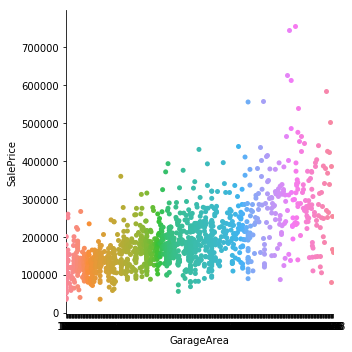

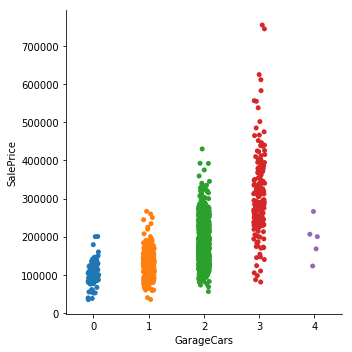

In [54]:
# EDA 
# - Which incomplete columns have predictive power?
# - How best to complete the incomplete continuous columns?

cont_incompl_col_names = ['BsmtFinSF1','BsmtFinSF2', 'BsmtFullBath','BsmtHalfBath', \
                         'BsmtUnfSF','GarageArea', 'GarageCars', 'GarageYrBlt' ,'LotFrontage', 'MasVnrArea','TotalBsmtSF']

# GarageArea and GarageCars are most strongly correlated with SalePrice
# I'll look at these two first.
train_dat[cont_incompl_col_names + ['SalePrice']].corr()
sns.catplot(x='GarageArea', y='SalePrice', data=train_dat)
sns.catplot(x='GarageCars', y='SalePrice', data=train_dat)

# Training data has values for these in every row.
# Test data is missing in one row.
train_dat[['GarageArea','GarageCars']].info()
test_dat[['GarageArea','GarageCars']].info()


In [157]:
# Filling GarageArea and GarageCars with null entries with the column mean

cont_col_names = ['LotArea', '1stFlrSF','2ndFlrSF','LowQualFinSF', 'GrLivArea', 'FullBath', \
                  'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'Fireplaces', \
                  'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', \
                  'PoolArea', 'MiscVal','YrSold', 'YearBuilt', 'YearRemodAdd']

cat_col_names = ['MSSubClass','Street', 'LotShape','LandContour', 'LotConfig','LandSlope', 'Neighborhood', \
                 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', \
                 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', \
                 'PavedDrive', 'MoSold']

cont_incompl_col_names = ['GarageArea', 'GarageCars']

cont_incompl_cols = train_dat[cont_incompl_col_names]
cont_imputed_cols = cont_incompl_cols.fillna(cont_incompl_cols.mean())

X = one_hotify_train(cont_col_names, cat_col_names)
X = pd.concat([X, cont_imputed_cols], axis=1)
y = train_dat['SalePrice'].values
regr = linear_model.LinearRegression()
regr.fit(X,y)
y_hat = regr.predict(X)
error = log_rmse(y, y_hat)
print('Error: {}'.format(error))

# Small increase in performance: 0.12827616685057144 -> 0.12645734752327922
# I am going to do this to all the incomplete columns..

Error: 0.12645734752327922


In [189]:
# EDA - why did performance increase on the training set and decrease on the test set?

# Q: what happens if you drop features which have large numbers of NANs: [PoolQC, MiscFeature, FireplaceQu, Fence, Alley]
# A: Training Set error: 0.10473 -> 0.10519, 
#    Test Set error: 0.21408 -> 0.19849



Error: 0.1051942735066285


                YrSold  YearBuilt  YearRemodAdd  SalePrice
YrSold        1.000000  -0.013618      0.035743  -0.028923
YearBuilt    -0.013618   1.000000      0.592855   0.522897
YearRemodAdd  0.035743   0.592855      1.000000   0.507101
SalePrice    -0.028923   0.522897      0.507101   1.000000


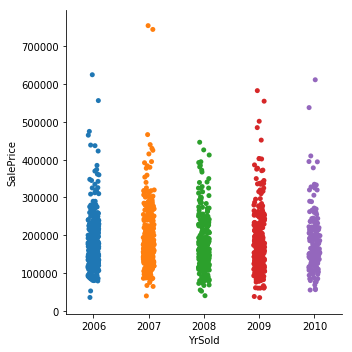

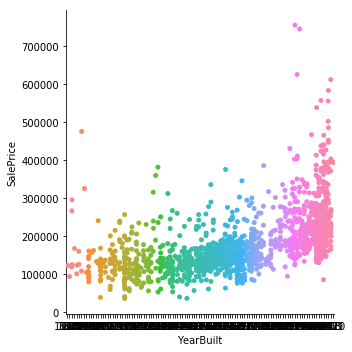

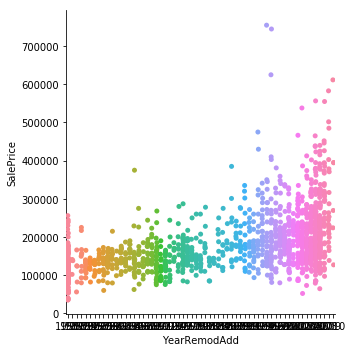

In [29]:
# EDA - years features

# YearRemodAdd and YearBuilt are strongly correlated with the SalePrice
# YrSold is not strongly correlated with the SalePrice
print(labelled_dat[['YrSold', 'YearBuilt', 'YearRemodAdd', 'SalePrice']].corr())

# There isn't much difference in distribution of SalePrice year to year
sns.catplot(x='YrSold', y='SalePrice', data=labelled_dat)

# YearBuilt correlation with SalePrice:
sns.catplot(x='YearBuilt', y='SalePrice', data=labelled_dat)
#print(train_dat['YearBuilt'].describe())

# YearRemodAdd correlation with SalePrice:
# There's an anomalous line of datapoints along y axis.
sns.catplot(x='YearRemodAdd', y='SalePrice', data=labelled_dat)


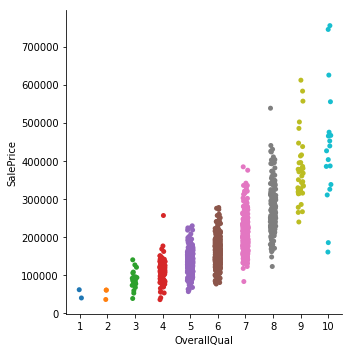

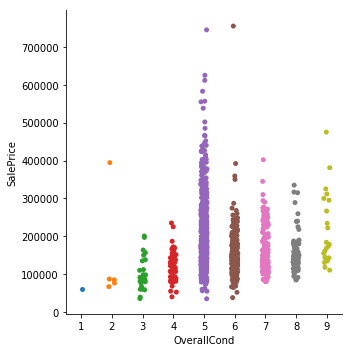

In [170]:
# EDA - OverallQual/Cond

# Perhaps unsurprisingly, quality and condition are pretty good predictors of SalePrice:
sns.catplot(x='OverallQual', y='SalePrice', data=train_dat)
sns.catplot(x='OverallCond', y='SalePrice', data=train_dat)

In [156]:
# MODEL 7 - Treating OverallQual/Cond as continuous rather than one-hot encoded categoricals

cont_col_names = ['LotArea', '1stFlrSF','2ndFlrSF','LowQualFinSF', 'GrLivArea', 'FullBath', \
                  'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'Fireplaces', \
                  'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', \
                  'PoolArea', 'MiscVal','YrSold', 'YearBuilt', 'YearRemodAdd','OverallQual', 'OverallCond']

cat_col_names = ['MSSubClass','Street', 'LotShape','LandContour', 'LotConfig','LandSlope', 'Neighborhood', \
                 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', \
                 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', \
                 'PavedDrive', 'MoSold']

# regression - train
# ---------------------------
X = one_hotify_train(cont_col_names, cat_col_names)
y = train_dat['SalePrice'].values
regr = linear_model.LinearRegression()
regr.fit(X,y)
y_hat = regr.predict(X)
error = log_rmse(y, y_hat)
print('Error: {}'.format(error))

# regression - predict
# ---------------------------
cont_cols = test_dat[cont_col_names]
#X = pd.concat([gen_one_hot(test_dat, cat_col_names), cont_cols, test_fill_frame], axis=1)
#X = X.reindex(sorted(X.columns),axis=1)
X = one_hotify_test(cont_col_names, cat_col_names)
y_hat = regr.predict(X)

# Performs WORSE than previous model - not submitting.


Error: 0.14494913196604853
